# Lecture 29: Temperature Scaling

### next token chosen based on the largest probablity score among all tokens in the vocabulary

### sample the next token from a probability distribution by using Temperature scaling and Top K-Sampling

### multinominal probability distribution, sampling the next token according to probability score

## decoding strategies to control randomness

In [197]:
from model_with_feature_classes import GPTModel
import torch
from torch import nn 
import tiktoken
from helper_functions import generate_text_simple, text_to_token_ids, token_ids_to_text
import matplotlib.pyplot as plt


In [198]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [199]:
device = "cpu"
device

'cpu'

In [ ]:
torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

checkpoint = torch.load("gpt_pretrained.pt", map_location="cpu")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

model.train()

GPTModel(
  (input_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layer_stack): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_f

In [201]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=50,
    context_size=GPT_CONFIG_124M["context_length"]
)

print(f"Output text:\n{token_ids_to_text(token_ids, tokenizer)}")

Output text:
Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"

He laughed again, and threw back his head to the donkey again. I saw that, and down the room, when I


In [202]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {}

for word, index in vocab.items():
    inverse_vocab[index] = word

print(vocab)
print(inverse_vocab)

{'closer': 0, 'every': 1, 'effort': 2, 'forward': 3, 'inches': 4, 'moves': 5, 'pizza': 6, 'toward': 7, 'you': 8}
{0: 'closer', 1: 'every', 2: 'effort', 3: 'forward', 4: 'inches', 5: 'moves', 6: 'pizza', 7: 'toward', 8: 'you'}


In [203]:
torch.set_printoptions(precision=4, sci_mode=False)
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
    )

probas = torch.softmax(next_token_logits, dim=-1)

next_token = torch.argmax(probas, dim=-1).item()

print(f"Pre Softmax:\n{next_token_logits}")
print(f"Row sum: {torch.sum(next_token_logits, dim=-1):.3f}")
print(f"\nPost Softmax:\n{probas}")
print(f"Row sum: {torch.sum(probas, dim=-1):.3f}")
print(f"\nid of next token in vocab:\n {next_token}\nnext token:\n {inverse_vocab[next_token]}")

Pre Softmax:
tensor([ 4.5100,  0.8900, -1.9000,  6.7500,  1.6300, -1.6200, -1.8900,  6.2800,
         1.7900])
Row sum: 16.440

Post Softmax:
tensor([    0.0609,     0.0016,     0.0001,     0.5721,     0.0034,     0.0001,
            0.0001,     0.3576,     0.0040])
Row sum: 1.000

id of next token in vocab:
 3
next token:
 forward


## implement probabilistic sampling by replacing the argmax function with the multinominal function

In [204]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()

print(inverse_vocab[next_token_id])

toward


In [205]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


## temperature scaling dividing the logits by a value greater than 0

In [206]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

temperatures = [1, 0.1, 5]

scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

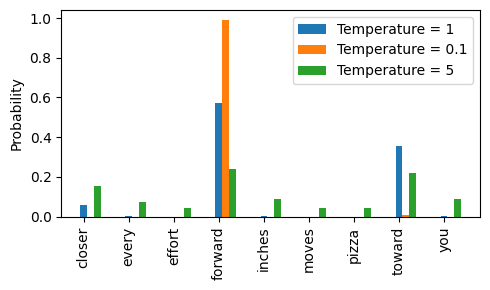

In [207]:
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f"Temperature = {T}")

ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
#plt.savefig("temperature-plot.pdf")
plt.show()

# Lecture 30: top-k sampling

### find the top 3 values in the logits tensor, number of values to be considered determined by integer, topk function retrieves the values and their respective position within the tensor

In [208]:

next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
    )
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print(f"Top logits: {top_logits}")
print(f"Top position: {top_pos}")

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top position: tensor([3, 7, 0])


### replace all other values in the tensor with negative infinity

In [209]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


### apply softmax

In [210]:
new_probas = torch.softmax(new_logits, dim=-1)

print(new_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### workflow ---> logits --> topk --> logits / temperature --> softmax --> sample from multinomial

In [211]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature

            probs = torch.softmax(logits, dim=-1)

            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdims=True)
        
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [212]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=30,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=10,
    temperature=1.3
)

print(f"Output text:\n {token_ids_to_text(token_ids, tokenizer)}")

Output text:
 Every effort moves you know
